### Import necessary modules

In [ ]:

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests, json, random, time, tqdm, warnings
seed=111
path='/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/'

### Loading data

In [2]:
r1=pd.read_pickle(path+'prices_0_200.pkl')
r2=pd.read_pickle(path+'prices_200_578.pkl')
r3=pd.read_pickle(path+'prices_577_777.pkl')
r4=pd.read_pickle(path+'prices_777_1000.pkl')
r5=pd.read_pickle(path+'prices_1000_1500.pkl')
r6=pd.read_pickle(path+'prices_1500_2000.pkl')
r7=pd.read_pickle(path+'prices_2000_3000.pkl')
r8=pd.read_pickle(path+'prices_3000_3240.pkl')
r9=pd.read_pickle(path+'prices_3240_4000.pkl')
r10=pd.read_pickle(path+'prices_4000_.pkl')
#print(len(r1), len(r2), len(r3), len(r4), len(r5), len(r6))
r=r1.append(r2, ignore_index=True)
r=r.append(r3, ignore_index=True)
r=r.append(r4, ignore_index=True)
r=r.append(r5, ignore_index=True)
r=r.append(r6, ignore_index=True)
r=r.append(r7, ignore_index=True)
r=r.append(r8, ignore_index=True)
r=r.append(r9, ignore_index=True)
r=r.append(r10, ignore_index=True)


r.to_pickle('scraping_data.pkl')


### Cleaning

In [7]:
r=pd.read_pickle('scraping_data.pkl')
t=pd.read_pickle(path+'/Prediction/missings_190528.pkl')
r=r.append(t, ignore_index=True)
missings2018_1= pd.read_pickle('missings_2018_del1.pkl')
missings2018_2= pd.read_pickle('missings_2018_del2.pkl')
missings2018_3= pd.read_pickle('missings_2018_del3.pkl')
r=r.append(missings2018_1, ignore_index=True)
r=r.append(missings2018_2, ignore_index=True)
r=r.append(missings2018_3, ignore_index=True)

r=r.loc[(r.price !='-') & (r.price != 'Ingen')]
r=r.drop_duplicates(['origin','destination'])
r['price']=r['price'].str[4:].str.replace('.','')
r['price']=pd.to_numeric(r.price, errors='coerce')
r=r.drop_duplicates(['origin','destination'])
pred=pd.read_pickle(path+'FlightsML18.pkl')

pred_data=r.merge(pred, how='right', left_on=['origin','destination'], right_on=['Origin', 'Dest'])


missings = pred_data[pred_data['price'].isna()==True]
missings = missings[missings['count']>52]
missings = missings[missings['day'].isna()==True]
missings = missings[['Origin','Dest']]
missings.to_pickle('missings18.pkl')
pred_data=pred_data[pred_data['count']>=52]
pred_data = pred_data[pred_data['price'].isna()!=True]
pred_data = pred_data[pred_data['price']<5000]
pred_data.to_pickle('pred_data_2018.pkl')

### Creating data sets

In [130]:
pred_data=pd.read_pickle('pred_data_2018.pkl')
X_base=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies','Origin','Dest', 'label']]
y_base=pred_data['price']

X=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef', 'Origin','Dest', 'label']]
y=pred_data['price']

X_base=pd.get_dummies(data=X_base, columns=['companies','Origin', 'Dest', 'label'])
X=pd.get_dummies(data=X, columns=['companies','Origin', 'Dest', 'label'])
#X.drop(['Origin','Dest'], inplace=True, axis=1)

### Correlation plot

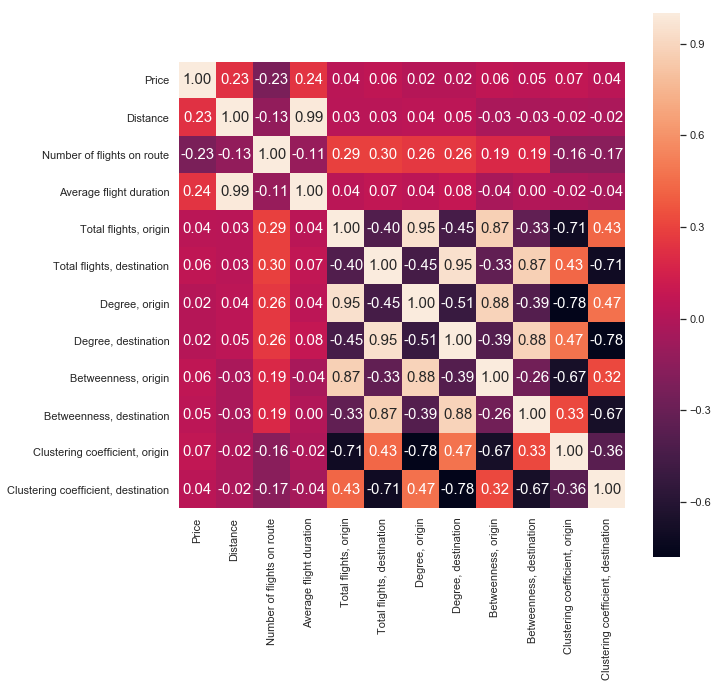

In [131]:
# Look at the Correlation matrix
cols = ['price','Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef']
names = ['Price', 'Distance', 'Number of flights on route', 'Average flight duration', 'Total flights, origin',
        'Total flights, destination', 'Degree, origin', 'Degree, destination', 'Betweenness, origin',
        'Betweenness, destination', 'Clustering coefficient, origin', 'Clustering coefficient, destination']
fig4, hm = plt.subplots(figsize=(10,10))
cm = np.corrcoef(pred_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=names, xticklabels=names)
plt.savefig(path+"Figures/corr_plot.pdf", bbox_inches='tight')


### Splitting data

In [132]:
# Splitting the data into test and training
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
X_dev_base, X_test_base, y_dev_base, y_test_base = train_test_split(X_base, y_base, test_size=1/4, random_state=1)



### Estimating network model

In [208]:
# Scaling data
scaler = StandardScaler()
scaler.fit(X_dev)
X_dev=scaler.transform(X_dev)

# Create the hyperparameter grid
l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'alpha':alpha, 'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, return_train_score=True)

# Fit it to the training data
gm_cv.fit(X_dev, y_dev)

scaler.fit(X_test)
X_test=scaler.transform(X_test)
# Predict on the test set and compute metrics
y_pred_train = gm_cv.predict(X_dev)
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


Tuned ElasticNet l1 ratio: {'alpha': 6.358974358974359, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.41386426036144136
Tuned ElasticNet MSE: 356981.519216037


### Computing training data statistics for network model

In [205]:
k=cross_val_score(ElasticNet(tol=0.001, alpha=6.358974358974359, l1_ratio=1), X=X_dev, y=y_dev, cv=5)
k2=cross_val_predict(ElasticNet(tol=0.0001, alpha=6.358974358974359, l1_ratio=1), X=X_dev, y=y_dev, cv=5)
mse=mean_squared_error(y_dev, k2)
r2=np.mean(k)
r2_std=np.std(k)
print(mse, r2, r2_std)

0.4343737200605659 0.029037351186267216


### Validation Curve

In [194]:

scores=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=1), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores.append(data)
scores=pd.DataFrame(scores)

scores_l1=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=0.75), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores_l1.append(data)
scores_l1=pd.DataFrame(scores_l1)

scores_l1_2=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=0.5), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores_l1_2.append(data)
scores_l1_2=pd.DataFrame(scores_l1_2)

scores_test=[]
for a in range(1,15,1):
    k=ElasticNet(tol=0.001, alpha=a, l1_ratio=1)
    k.fit(X=X_dev, y=y_dev)
    score=k.score(X_test, y_test)
    data={'alpha':a, 'score':score}
    #df=pd.DataFrame(data)
    scores_test.append(data)
scores_test=pd.DataFrame(scores_test)



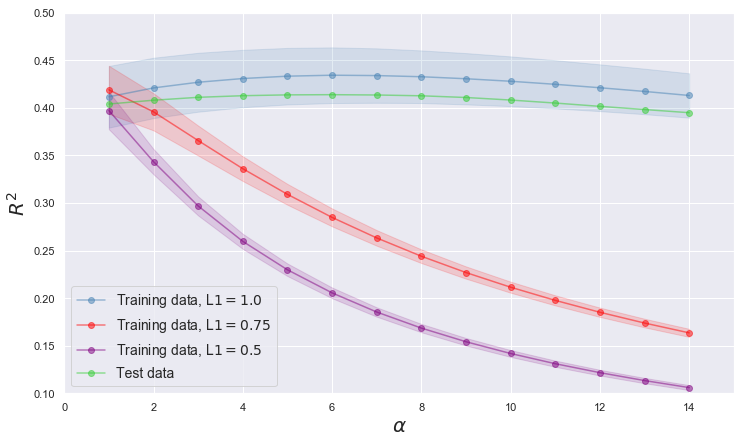

In [203]:
scores['conf1']=scores['score'] + scores['std']
scores['conf2']=scores['score'] - scores['std']
scores_l1['conf1']=scores_l1['score'] + scores_l1['std']
scores_l1['conf2']=scores_l1['score'] - scores_l1['std']
scores_l1_2['conf1']=scores_l1_2['score'] + scores_l1_2['std']
scores_l1_2['conf2']=scores_l1_2['score'] - scores_l1_2['std']
plt.figure(figsize=(12,7))
plt.plot(scores.alpha , scores.score,
    c='steelblue', marker='o',
    label='Training data, L$1=1.0$', alpha=0.5)
plt.plot(scores_l1.alpha , scores_l1.score,
    c='red', marker='o',
    label='Training data, L$1=0.75$', alpha=0.5)
plt.plot(scores_l1_2.alpha , scores_l1_2.score,
    c='purple', marker='o',
    label='Training data, L$1=0.5$', alpha=0.5)
plt.plot(scores_test.alpha , scores_test.score,
    c='limegreen', marker='o',
    label='Test data', alpha=0.5)
plt.fill_between(scores.alpha , scores.conf1,
    scores.conf2, alpha=0.15,
    color='steelblue')
plt.fill_between(scores_l1.alpha , scores_l1.conf1,
    scores_l1.conf2, alpha=0.15,
    color='red')
plt.fill_between(scores_l1_2.alpha , scores_l1_2.conf1,
    scores_l1_2.conf2, alpha=0.15,
    color='purple')
plt.xlabel('$\\alpha$', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.legend(loc='lower left', fontsize=14)
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 15])
plt.ylim([0.1, 0.5])
plt.savefig(path+"Figures/validation_curve.pdf", bbox_inches='tight')
plt.show()


### Residuals plot

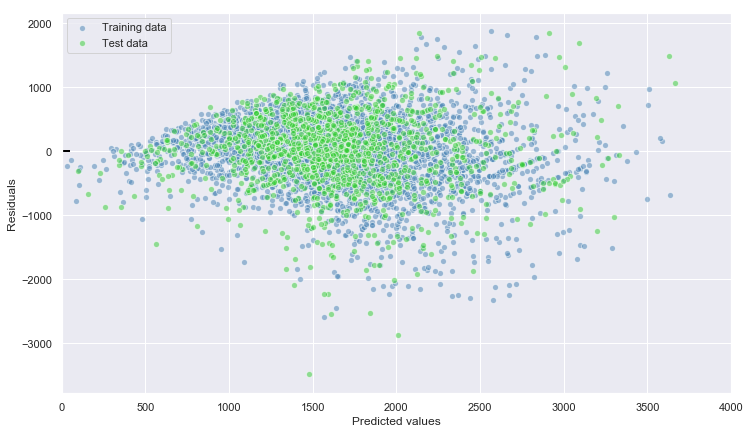

In [199]:
# Residuals plot
plt.figure(figsize=(12,7))
y_pred_train = gm_cv.predict(X_dev)
res_pred_test = y_pred-y_test
res_pred_train = y_pred_train-y_dev
plt.scatter(y_pred_train, res_pred_train ,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data', alpha=0.5)
plt.scatter(y_pred, res_pred_test,
    c='limegreen', marker='o', edgecolor='white',
    label='Test data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0,4000])
plt.show()

### Estimating baseline model

In [210]:
#Without network

# Create the hyperparameter grid

scaler.fit(X_dev_base)
X_dev_base=scaler.transform(X_dev_base)

l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'l1_ratio': l1_space, 'alpha':alpha}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv_base = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv_base.fit(X_dev_base, y_dev_base)

scaler.fit(X_test_base)
X_test_base=scaler.transform(X_test_base)

# Predict on the test set and compute metrics
y_pred_base_train = gm_cv_base.predict(X_dev_base)
y_pred_base = gm_cv_base.predict(X_test_base)
r2 = gm_cv_base.score(X_test_base, y_test_base)
mse = mean_squared_error(y_test_base, y_pred_base)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv_base.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


Tuned ElasticNet l1 ratio: {'alpha': 6.358974358974359, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.4111790891634505
Tuned ElasticNet MSE: 358616.9023342973


### Computing training data statistics for baseline model

In [207]:
k=cross_val_score(ElasticNet(tol=0.0001, alpha=6.358974358974359, l1_ratio=1), X=X_dev_base, y=y_dev_base, cv=5)
k2=cross_val_predict(ElasticNet(tol=0.0001, alpha=6.358974358974359, l1_ratio=1), X=X_dev_base, y=y_dev_base, cv=5)
mse=mean_squared_error(y_dev_base, k2)
r2=np.mean(k)
r2_std=np.std(k)
print(mse, r2, r2_std)

363057.6883244896 0.43174016205424526 0.02942835642953338


### Comparing coefficients (manuelly)

In [42]:
gm_cv_base.best_estimator_.coef_
gm_cv.best_estimator_.coef_

var=['Distance','count', 'avg_time_mins', 'Origin_flights', 
    'Destination_flights','origin_degree', 'dest_degree', 'origin_btwns', 
    'dest_btwns','origin_clustcoef', 'dest_clustcoef']
var=pd.DataFrame(var)
coef_model1= [0.00000000e+00, -1.49232389e+02,  2.42153333e+02,  1.09157570e+00,
    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.09370059e+01,
    3.83201347e+01,  9.58314028e+01,  2.08122417e+01]
coef_model1=pd.DataFrame(coef_model1)

coef_model2=[0.00000000e+00, -1.52497736e+02,  2.39954256e+02,  0.00000000e+00,
    1.26775030e+01] 
coef_model2=pd.DataFrame(coef_model2)

coefs=pd.concat([var,coef_model1,coef_model2], axis=1)
coefs

array([ 0.00000000e+00, -1.72149315e+02,  2.47932097e+02,  0.00000000e+00,
        4.40730719e+00, -0.00000000e+00,  0.00000000e+00,  1.35105827e+01,
        0.00000000e+00, -0.00000000e+00,  4.70166324e+00,  0.00000000e+00,
        0.00000000e+00, -2.15071173e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.40177230e+00,  1.53653852e+01,
        0.00000000e+00,  0.00000000e+00, -6.76360705e+00,  3.09630424e+01,
        2.96317901e+01,  2.42119174e+00,  8.10355447e-01,  1.08835190e+00,
        0.00000000e+00, -3.46151609e+01,  3.42755787e+00, -0.00000000e+00,
       -1.31214705e+01, -1.09949594e+00,  7.47850868e+00,  0.00000000e+00,
       -6.17998209e-01, -0.00000000e+00,  8.92553310e+00,  2.46067042e+01,
       -1.68923698e+00, -1.21762948e+01, -1.46635501e+01, -0.00000000e+00,
        1.14004858e+01,  8.74833130e+00, -0.00000000e+00, -5.16576754e+01,
       -0.00000000e+00,  0.00000000e+00, -2.63720912e+00, -4.53402220e+00,
       -3.14426202e+00, -